In [1]:
# from PIL import Image
import os

In [2]:
path = "F:/data/flickr30k_images/flickr30k_images/"
train_images_list = os.listdir(path)

In [3]:
len(train_images_list)

31785

In [4]:
sample_size = 30
train_images_list = train_images_list[:sample_size]

In [5]:
len(train_images_list)

30

In [6]:
import tensorflow  as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pandas as pd

In [7]:
size = (256,256)
num_channels = 3

In [8]:
train = np.array([None] * sample_size)
real_images  = np.array([None] * sample_size)

In [9]:
j = 0
for i in train_images_list:
    real_images[j] = np.array(plt.imread(path + i))
    train[j] = np.array(plt.imread(path + i))
    j += 1

In [10]:
j= 0
for i in train:
    train[j] = cv2.resize(i , size)
    train[j] = train[j].reshape(1, size[0],size[1] , num_channels)
    j += 1

In [11]:
train = np.vstack(train[:])

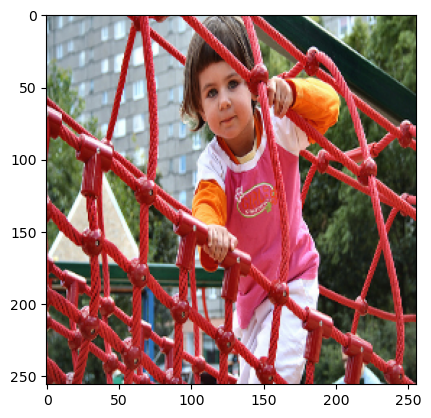

In [12]:
from PIL import Image
plt.imshow(np.squeeze(train[28]))
plt.show()

In [13]:
train_captions = pd.read_csv("F:/data/flickr30k_images/results.csv", delimiter ="|" )

In [14]:
train_captions

image_name  comment_number  \
0       1000092795.jpg               0   
1       1000092795.jpg               1   
2       1000092795.jpg               2   
3       1000092795.jpg               3   
4       1000092795.jpg               4   
...                ...             ...   
158910   998845445.jpg               0   
158911   998845445.jpg               1   
158912   998845445.jpg               2   
158913   998845445.jpg               3   
158914   998845445.jpg               4   

                                                  comment  
0        Two young guys with shaggy hair look at their...  
1        Two young , White males are outside near many...  
2        Two men in green shirts are standing in a yard .  
3            A man in a blue shirt standing in a garden .  
4                 Two friends enjoy time spent together .  
...                                                   ...  
158910   A man in shorts and a Hawaiian shirt leans ov...  
158911   A young man hanging over the side of a boat ,...  
158912   A man is leaning off of the side of a blue an...  
158913   A man riding a small boat in a harbor , with ...  
158914   A man on a moored blue and white boat with hi...  

[158915 rows x 3 columns]

In [15]:
def get_images_ids(names):
    names = [int(x.split("_")[-1].split(".")[0]) for x in names]
    return names

In [16]:
ids = get_images_ids(train_images_list[:sample_size])

In [17]:
train_captions.columns = ["image_name","comment_number","comment"]

In [18]:
def images_map_caption(train_images_list , train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions["image_name"] == i]["comment"].iat[0])

    return caption

In [19]:
captions = np.array(images_map_caption(train_images_list,train_captions))
print(captions.shape)

(30,)


In [20]:
import re

In [21]:
start_tag = "<s>"
end_tag = "<e>"

In [22]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m

    j = 0

    for i in captions:
        i = re.sub(" +"," ", i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    for i in arr :
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence , fwd_dict , rev_dict 

In [23]:
vocab_size , sentences , fwd_dict , rev_dict = get_vocab(captions)

In [24]:
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [25]:
m = len(sentences)
train_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data ,(row, col)) , shape=(1,vocab_size))
        else:
            cap_array = vstack((cap_array , csr_matrix((data, (row, col)) , shape=(1, vocab_size))))
    train_caption[i] = cap_array
    i += 1

In [26]:
train_caption[0].shape

(19, 230)

# **Model architecture**

### Training Model

In [27]:
def create_weights(shape , suffix):
    return tf.Variable(tf.random.truncated_normal(shape, stddev= 0.7), name='W_' + suffix)


def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]) , name="b_" + suffix)

In [28]:
def conv_layer(input , kernel_shape , num_channels , num_kernels , suffix):
    filter_shape = [kernel_shape[0] , kernel_shape[1],num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases =create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=input , filters= weights  ,padding="SAME", strides=[1,1,1,1] , name="conv_" + suffix)
    layer += biases
    layer = tf.nn.relu(layer , name="relu_" + suffix)
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1] , strides= [1,2,2,1] , padding="SAME")
    return layer

In [29]:
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer

In [30]:
def dense_layer(inp, num_inputs , num_outputs , suffix , use_relu=True):
    weights = create_weights([num_inputs , num_outputs] , suffix)
    biases = create_biases(num_outputs , suffix)
    layer = tf.matmul(inp , weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [31]:
def rnn_cell(Win , Wout,  Wfwd , b , hprev , input):
    h = tf.tanh(tf.add(tf.add(tf.matmul(input,Win) , tf.matmul(hprev,Wfwd)) , b))
    out = tf.matmul(h, Wout)
    return h , out

In [32]:
tf.device("/device:GPU:0")

In [33]:
learning_rate = 0.0001
training_iters = 5000
display_step = 1000
max_sent_limit = 50
num_tests = 12
bridge_size = 1024
keep_prob = 0.3

In [34]:
x_caption = tf.keras.Input(shape=(None ,vocab_size), dtype=tf.float32, name="x_caption")

x_input = tf.keras.Input(shape=(size[0], size[1], num_channels), dtype=tf.float32, name="x_image")

y = tf.keras.Input(shape=(None, vocab_size), dtype=tf.float32, name="x_caption")

In [35]:
Wconv = tf.Variable(tf.random.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi = tf.Variable(tf.random.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf = tf.Variable(tf.random.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo = tf.Variable(tf.random.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))


In [36]:
# Convolutional layer 1
layer_conv1 = conv_layer(input=x_input, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')

# Convolutional layer 2
layer_conv2 = conv_layer(input=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')

# Max pooling layer 1
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Convolutional layer 3
layer_conv3 = conv_layer(input=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')

# Convolutional layer 4
layer_conv4 = conv_layer(input=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')

# Max pooling layer 2
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Convolutional layer 5
layer_conv5 = conv_layer(input=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')

# Convolutional layer 6
layer_conv6 = conv_layer(input=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')

# Max pooling layer 3
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Convolutional layer 7
layer_conv7 = conv_layer(input=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')

# Convolutional layer 8
layer_conv8 = conv_layer(input=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')


In [37]:
flat_layer = flatten_layer(layer_conv8 , suffix="9")

dense_layer_1 = dense_layer(inp=flat_layer , num_inputs = 256 , num_outputs=bridge_size , suffix="10")

In [38]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[start_tag]])), shape=(1,vocab_size)).A , tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0] , [fwd_dict[end_tag]])) , shape=(1, vocab_size)).A , tf.float32)

In [39]:
input_shape = tf.shape(x_caption)
hook = tf.slice(x_caption, [0, 0, 0], [input_shape[0], input_shape[1], vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi, Wo, Wconv, bconv, h, hook)

In [40]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi,Wo,Wf,b, h, curr)
    return h, out

In [41]:
_ , output = tf.scan(fn, x_caption[1:] , initializer = (h, out))

  <tf.Variable 'Variable:0' shape=(230, 230) dtype=float32>
  <tf.Variable 'Variable:0' shape=(230, 230) dtype=float32>
  <tf.Variable 'Variable:0' shape=(1, 230) dtype=float32>. This is a strong indication that the Lambda layer should be rewritten as a subclassed Layer.


In [42]:
output = tf.squeeze(output , axis=1)

In [43]:
outputs = tf.concat([out, output], axis=0)

In [61]:
# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_(logits=outputs, labels=y))

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate).minimize(cost)


In [46]:
pred = tf.nn.softmax(outputs)

In [47]:
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Predictive Model

In [48]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size=0)

In [ ]:
htest = dense_layer_1
htest, out_first = rnn_cell(Wi,Wo,Wconv,bconv,htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1) , depth =vocab_size)

out_tensor = out_tensor.write(t, out_)

t += 1

In [52]:
def condition(res, h , out_tensor , t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[end_tag])), tf.less(t, max_sent_limit))

In [53]:
def action(res, h, out_tensor ,t):
    h , out = rnn_cell(Wi, Wo, Wf,b,h,res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h , out_tensor , t + 1 

In [59]:
 # _ , __  , final_outputs, T =  tf.while_loop(condition , action, [out_,htest , out_tensor , t])

In [58]:
# final_prediction = tf.squeeze(final_outputs.stack())

In [57]:
# saver = tf.train.Saver()
# init = tf.global_variables_initializer()